In [4]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [3]:
! pip install tqdm

     |████████████████████████████████| 61kB 23.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import torch
import torch.distributions
import torch.nn as nn
from tqdm.auto import tqdm
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from torch.autograd import Variable
import pickle as pkl
import torch.optim as optim
from matplotlib import pyplot as plt
import torch
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split
import random
import os
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [37]:
EPS = 1e-6

In [7]:
file = open('hw2_q2.pkl', 'rb')
images = pkl.load(file)

In [19]:
x_train = np.transpose(images['train'], [0, 3, 1, 2])
x_test = np.transpose(images['test'], [0, 3, 1, 2])

In [20]:
x_train.shape, x_test.shape

((20000, 3, 32, 32), (6838, 3, 32, 32))

In [79]:
class DataLoader:
    def __init__(self, data, target, batch_size=10):
        self.data = data
        self.target = target
        self.batch_size = batch_size

    def next(self):
        m, _ = self.data.shape
        rand_index = np.random.choice(m, size=m)
        X, y = self.data[rand_index], self.target[rand_index]
        pos = 0
        while pos < m:
            X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
            yield (X_batch, y_batch)
            pos += self.batch_size

    def __call__(self):
        return self.next()

In [80]:
class ResBlock(nn.Module):
    def __init__(self, in_num, filts_num=32):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_num, filts_num, (1, 1))
        self.conv2 = nn.Conv2d(filts_num, filts_num, (3, 3), padding=1)
        self.conv3 = nn.Conv2d(filts_num, in_num, (1, 1))
        
    def forward(self, x):
        c1 = self.conv1(x)
        relu = torch.relu(c1)
        c2 = self.conv2(c1)
        relu = torch.relu(c2)
        c3 = self.conv3(relu)
        return x + c3

In [81]:
class ResNet(nn.Module):
    def __init__(self, in_num=3, filts_num=32, blocks_num=4):
        super(ResNet, self).__init__()
        out_num = in_num * 2        
        self.conv1 = nn.Conv2d(in_num, filts_num, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(filts_num, out_num, (3, 3), padding=1)
        self.blocks = nn.ModuleList()
        for _ in range(blocks_num):
            self.blocks.append(ResBlock(filts_num, filts_num))
        
    def forward(self, x):
        h = self.conv1(x)
        for block in self.blocks:
            h = block(h)
        relu = torch.relu(h)
        out = self.conv2(relu)
        return out

In [90]:
def logit(x, rev=False):
    if rev:
        return torch.exp(x) / (torch.exp(x) + 1.0)
    else:    
        t = torch.abs(1.0 / x + 1.0 / (1.0 - x))
        logdet = torch.log(t.flatten(start_dim=1) + EPS).sum(dim=1, keepdim=True)
        return torch.log(x) - torch.log(1.0 - x), logdet

def dequantize(x, alpha=0.05, rev=False):
    if rev:
        return 4.0 * (x - alpha) / (1.0 - alpha)
    else:
        t = torch.ones_like(x) * (1.0 - alpha) / 4.0
        logdet = torch.log(torch.abs(t.flatten(start_dim=1))).sum(dim=1, keepdim=True)
        return alpha + (1.0 - alpha) * x / 4.0, logdet
    
def preprocess(x, alpha=0.05, rev=False):
    if rev:
        return dequantize(logit(x, rev), alpha, rev)
    else:
        deq, logdet1 = dequantize(x, alpha, rev)
        z, logdet2 = logit(deq, rev)
        return z, logdet1 + logdet2

In [91]:
class CouplingLayer(nn.Module):
    def __init__(self, c=3, h=32, w=32, filts_num=32, blocks_num=4, mask=None):
        super(CouplingLayer, self).__init__()
        self.register_buffer("mask", torch.ones([1, c, h, w], dtype=torch.float32))
        if mask is not None:
            self.mask.data.copy_(mask)
        self.c = c
        self.resNet = ResNet(self.c, filts_num, blocks_num)
    
    def forward(self, x, rev=False):
        if not rev:
            z = self.mask * x
            log_s, t = torch.split(self.resNet(z), z.shape[1], dim=1)
            log_s = torch.tanh(log_s)
            z = z + (1.0 - self.mask) * (torch.exp(log_s) * x + t)
            logdet = torch.sum(torch.flatten(log_s * (1.0 - self.mask), start_dim=1), dim=1, keepdim=True)
            return z, logdet
        else:
            z = self.mask * x
            log_s, t = torch.split(self.resNet(z), z.shape[1], dim=1)
            log_s = torch.tanh(log_s)
            z = z + (1.0 - self.mask) * (x - t) / torch.exp(log_s)
            return z

In [92]:
def buildCheckerboardMask(c, h, w):
    maskA = np.ones([1, c, h, w], dtype=np.bool)
    maskB = np.ones([1, c, h, w], dtype=np.bool)
    even_idx = [i for i in range(w) if not i & 1]
    odd_idx = [i for i in range(h) if i & 1]
    maskA[:, :, odd_idx,:] = False 
    maskB[:, :, :, even_idx] = False
    mask = maskA ^ maskB
    return torch.from_numpy(mask).float()

In [93]:
def squeeze(x):
    n, c, h, w = x.shape
    return F.unfold(x, (2, 2), stride=2).reshape([n, 4 * c, h // 2, w // 2])

def unsqueeze(x):
    n, c, h, w = x.shape
    return F.fold(x.reshape([n, c, -1]), (h * 2, w * 2), (2, 2), stride=2)


def buildChannelSplitMask(c, h, w):
    mask = torch.zeros([1, c, h, w], dtype=torch.float32)
    idx = np.array([[4 * i, 4 * i + 1] for i in range(c // 4)]).reshape(-1)

    mask[:, idx, :, :] = 1.0
    return mask

In [94]:
class ActNorm(nn.Module):
    def __init__(self, c, h, w):
        super(ActNorm, self).__init__()
        self.register_parameter("s", nn.Parameter(torch.ones([1, c, h, w])))
        self.register_parameter("b", nn.Parameter(torch.zeros([1, c, h, w])))
        
    def initialize(self, x):
        std = torch.std(x, dim=0, keepdim=True)
        self.s.data.copy_(1.0 / std)
        self.b.data.copy_(-torch.mean(x * self.s, dim=0, keepdim=True))
        
    def forward(self, x, rev=False):
        if not rev:
            logdet = torch.sum(torch.flatten(torch.log(torch.abs(self.s) + 1e-6), start_dim=1), dim=1, keepdim=True)
            out = x * self.s + self.b
            return out, logdet
        else:
            out = (x - self.b) / self.s
            return out

In [95]:
class RealNVP(nn.Module):    
    def __init__(self):
        super(RealNVP, self).__init__()
        self.affLayers1 = nn.ModuleList()
        mask = buildCheckerboardMask(3, 32, 32)
        for _ in range(4):
            self.affLayers1.append(CouplingLayer(3, 32, 32, mask=mask))
            self.affLayers1.append(ActNorm(3, 32, 32))
            mask = 1.0 - mask
        
        self.affLayers2 = nn.ModuleList()
        mask = buildChannelSplitMask(12, 16, 16)
        for _ in range(3):
            self.affLayers2.append(CouplingLayer(12, 16, 16, mask=mask))
            self.affLayers2.append(ActNorm(12, 16, 16))
            mask = 1.0 - mask
        
        self.affLayers3 = nn.ModuleList()
        mask = buildCheckerboardMask(12, 16, 16)
        for _ in range(3):
            self.affLayers3.append(CouplingLayer(12, 16, 16, mask=mask))
            self.affLayers3.append(ActNorm(12, 16, 16))
            mask = 1.0 - mask
            
        self.affLayers4 = nn.ModuleList()
        mask = buildChannelSplitMask(48, 8, 8)
        for _ in range(3):
            self.affLayers4.append(CouplingLayer(48, 8, 8, mask=mask))
            self.affLayers4.append(ActNorm(48, 8, 8))
            mask = 1.0 - mask
            
        self.affLayers5 = nn.ModuleList()
        mask = buildCheckerboardMask(48, 8, 8)
        for i in range(3):
            self.affLayers5.append(CouplingLayer(48, 8, 8, mask=mask))
            self.affLayers5.append(ActNorm(48, 8, 8))
            mask = 1.0 - mask

    def forward(self, x, rev=False):
        if not rev:
            x, logdet = preprocess(x)
            for layer in self.affLayers1:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
                
            x = squeeze(x)
            for layer in self.affLayers2:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
            for layer in self.affLayers3:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet

            x = squeeze(x)
            for layer in self.affLayers4:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet
            for layer in self.affLayers5:
                x, cur_logdet = layer(x)
                logdet = logdet + cur_logdet

            x = unsqueeze(x)
            x = unsqueeze(x)
            return x, logdet
        else:
            x = squeeze(x)
            x = squeeze(x)
            for layer in reversed(self.affLayers5):
                x = layer(x, rev=rev)
            for layer in reversed(self.affLayers4):
                x = layer(x, rev=rev)
            x = unsqueeze(x)
            for layer in reversed(self.affLayers3):
                x = layer(x, rev=rev)
            for layer in reversed(self.affLayers2):
                x = layer(x, rev=rev)
            x = unsqueeze(x)
            for layer in reversed(self.affLayers1):
                x = layer(x, rev=rev)
            x = preprocess(x, rev=rev)
            return x

    def initialize(self, x):
        with torch.no_grad():
            x, _ = preprocess(x)
            for layer in self.affLayers1:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)    
                
            x = squeeze(x)
            for layer in self.affLayers2:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x,  _ = layer(x)
            for layer in self.affLayers3:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)
                
            x = squeeze(x)
            for layer in self.affLayers4:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)
            for layer in self.affLayers5:
                if isinstance(layer, ActNorm):
                    layer.initialize(x)
                x, _ = layer(x)
                
                
def getNLL(z, logdet):
#     pz = torch.exp(-torch.pow(z, 2) / 2) / np.sqrt(2 * np.pi)
    m = torch.distributions.normal.Normal(0, 1)
    log_pz = m.log_prob(z) 
    log_pz = torch.sum(torch.flatten(log_pz, start_dim=1), dim=1, keepdim=True)
    nll = -(log_pz + logdet)
    return nll

In [96]:
batch_size = 64
n_epochs = 100
train_size = x_train.shape[0]
n_iter_per_epoch = train_size // batch_size
val_steps = n_iter_per_epoch // 8
lr = 1e-3
logs = {}

net = RealNVP().cuda()
opt = optim.Adam(net.parameters(), lr=lr)

train_log = []
val_log = []
global_step = 0

sample_idx = np.random.choice(np.arange(0, train_size), 128)
init_batch = torch.from_numpy(x_train[sample_idx]).float().cuda()
net.initialize(init_batch)

for epoch in range(n_epochs):
    idx = np.random.permutation(train_size)
    for i in range(n_iter_per_epoch):
        global_step += 1

        batch = torch.from_numpy(x_train[idx[i * batch_size: (i + 1) * batch_size], :]).float().cuda()
        z, logdet = net(batch)
        nll = getNLL(z, logdet)
        loss = torch.sum(nll, dim=0)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i % 30 == 0:
            print("Epoch-{:d}/{:d} Iter-{:d}/{:d}: Loss-{:.5f}".format(epoch + 1, n_epochs, i + 1, n_iter_per_epoch, loss.item()))
        train_nll = loss.detach() / (batch_size * 32 * 32 * 3 * np.log(2))
        train_log.append(train_nll.item())

        # validation
        if (global_step % val_steps == 0):
            with torch.no_grad():
                start_idx = 0
                val_size = x_test.shape[0]
                val_nll = torch.zeros([1]).float().cuda()
                while start_idx < val_size:
                    end_idx = min(val_size, start_idx + batch_size)
                    val_z, val_logdet = net(torch.from_numpy(x_test[start_idx:end_idx]).float().cuda())
                    val_nll = val_nll + torch.sum(getNLL(val_z, val_logdet))
                    start_idx += batch_size
                val_log.append(val_nll.item() / (val_size * 32 * 32 * 3 * np.log(2)))

Epoch-1/100 Iter-1/312: Loss-252656.84375
Epoch-1/100 Iter-31/312: Loss-57494.28125
Epoch-1/100 Iter-61/312: Loss-10821.04785
Epoch-1/100 Iter-91/312: Loss--22523.13086
Epoch-1/100 Iter-121/312: Loss--31062.04883
Epoch-1/100 Iter-151/312: Loss--60156.94141
Epoch-1/100 Iter-181/312: Loss--59012.39062
Epoch-1/100 Iter-211/312: Loss--63359.04297
Epoch-1/100 Iter-241/312: Loss--57983.73438
Epoch-1/100 Iter-271/312: Loss--72085.53125
Epoch-1/100 Iter-301/312: Loss--87501.34375
Epoch-2/100 Iter-1/312: Loss--92057.25000
Epoch-2/100 Iter-31/312: Loss--77116.32812
Epoch-2/100 Iter-61/312: Loss--104211.17188
Epoch-2/100 Iter-91/312: Loss--130139.96094


KeyboardInterrupt: 

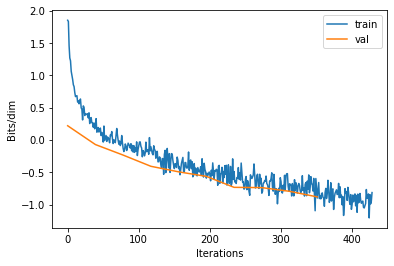

In [97]:
plt.plot(np.arange(len(train_log)), train_log, label="train")
plt.plot([i * 39 for i in np.arange(len(val_log))], val_log, label="val")
plt.xlabel("Iterations")
plt.ylabel("Bits/dim")
plt.legend()